In [5]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *

In [94]:
# ellipse area and circumferencce
def ellipsoid_volume(a, b,c):
    """Returns the volume of an ellipsoid parametrized as (x/a)^2 + (y/b)^2 + (z/c)^2 = 1."""
    return 4/3 * torch.pi * a * b * c

def ellipsoid_surface_area(a, b, c, p=1.6075):
    """Returns the approximate surface area of an ellipsoid."""
    a_p = a**p
    b_p = b**p
    c_p = c**p
    return 4 * torch.pi * (1/3 * (a_p*b_p + a_p*c_p + b_p*c_p))**(1/p)


def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles[0], angles[1], angles[2] # yaw, pitch, roll
    R = torch.stack([
        torch.stack([cos(alpha)*cos(beta), cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)*cos(gamma), cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)*sin(gamma)]),
        torch.stack([sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)*sin(gamma)]),
        torch.stack([-sin(beta), cos(beta)*sin(gamma), cos(beta)*cos(gamma)])
    ])
    return R

def generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll):
    phi = 2.0 * math.pi * torch.linspace(0.0, 1.0, sqrt_m).double()
    theta = math.pi * torch.linspace(0.05, 0.95, sqrt_m).double()
    phi, theta = torch.meshgrid(phi, theta)
    x = a * torch.sin(theta) * torch.cos(phi)
    y = b * torch.sin(theta) * torch.sin(phi)
    z = c * torch.cos(theta)
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    coords = torch.stack((x_flat, y_flat, z_flat), dim=0).double()
    angles = torch.tensor([yaw, pitch, roll], requires_grad=True, dtype=torch.float)
    rotation_matrix = rotation_matrix_3d(torch.deg2rad(angles)).double()
    rotated_coords = rotation_matrix @ coords
    return rotated_coords

def plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='blue', linestyle='-', linewidth=0.5, alpha=0.5, sqrt_m=25):
    coords = generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll).T.detach()
    x_rot = coords[:, 0].reshape(sqrt_m,sqrt_m)
    y_rot = coords[:, 1].reshape(sqrt_m,sqrt_m)
    z_rot = coords[:, 2].reshape(sqrt_m,sqrt_m)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')

    ax.plot_wireframe(x_rot.numpy(), y_rot.numpy(), z_rot.numpy(),
                      color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    ax.set_aspect('equal', adjustable='box')

def generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p):
    coords = generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll).detach()
    data = coords + nu * torch.randn(3, m, dtype=torch.float)
    data = data.unsqueeze(0)
    return data

def constraint_function(u, p=1.6075):
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    a = u[0]
    b = u[1]
    c = u[2]
    res = 4/3 * torch.pi * (a*b*c) - 1
    return res

def constraint_function_grad(u):
    if torch.is_tensor(u):
        u = u.detach().clone()
    else:
        u = torch.tensor(u)
    u.requires_grad = True
    with torch.enable_grad():
        res = constraint_function(u)
    constr_grad = torch.autograd.grad(res, u)[0]
    return constr_grad

def objective_function(u, X, u_prev=None):
    if not torch.is_tensor(u):
        u = torch.tensor(u).double()
    if not torch.is_tensor(X):
        X = torch.tensor(X).double()
    L = torch.diag(1/u[:3]**2).double()
    R = rotation_matrix_3d(u[3:6]).double() # assumes radians
    A = R @ L @ R.T
    XT_AX = torch.einsum('ji,jk,ki->i', X, A, X)
    b = torch.ones(X.shape[1])
    if u_prev is None:
        return torch.sum((XT_AX - b) ** 2)/100
    else:
        if not torch.is_tensor(u_prev):
            u_prev = torch.tensor(u_prev).double()
        return torch.sum((XT_AX - b) ** 2)/100 + torch.norm(u_prev - u)**2/100

def objective_function_grad(u, X, u_prev=None):
    if torch.is_tensor(u):
        u = u.detach().clone()
    else:
        u = torch.tensor(u)
    if torch.is_tensor(X):
        X = X.detach().clone()
    else:
        X = torch.tensor(X).double()
    if u_prev is not None:
        if torch.is_tensor(u_prev):
            u_prev = u_prev.detach().clone()
        else:
            u_prev = torch.tensor(u_prev)
    u.requires_grad = True
    with torch.enable_grad():
        res = objective_function(u, X, u_prev).double()
    obj_grad = torch.autograd.grad(res, u)[0].double()
    return obj_grad

# ellipse fitting
def fit_ellipsoid(xs, p=1.6075, method="default", with_jac=False, u_prev=None):
    """Find ellipsoid parameters u = (1/a^2, 1/b^2, 1/c^2) that best fit the data."""
    n_batches = xs.size(0)
    results = torch.zeros(n_batches, 6, dtype=torch.double)
    losses = torch.zeros(n_batches, 1, dtype=torch.double)
    for batch_number, x in enumerate(xs):
        X = x.detach().numpy()
        if u_prev is not None:
            u0 = u_prev[batch_number].detach().numpy()
        else:
            u0 = initialise_u(X, method)
        # u0 = initialise_u(X, method)
        if with_jac:
            eq_const = {'type': 'eq',
                        'fun' : lambda u: constraint_function(u).cpu().numpy(),
                        'jac' : lambda u: constraint_function_grad(u).cpu().numpy()
                        }
            ineq_const = {'type': 'ineq',
                        'fun' : lambda u: np.array([2*np.pi - u[3], 2*np.pi - u[4], 2*np.pi - u[5], u[3], u[4], u[5]])}
            res = opt.minimize(lambda u: objective_function(u, X, u_prev).detach().cpu().numpy(), u0, jac=lambda u: objective_function_grad(u,X, u_prev).cpu().numpy(), 
                            method='SLSQP', constraints=[eq_const, ineq_const],
                            options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
        else:
            eq_const = {'type': 'eq',
                        'fun' : lambda u: constraint_function(u).cpu().numpy(),
                        }
            ineq_const = {'type': 'ineq',
                        'fun' : lambda u: np.array([2*np.pi - u[3], 2*np.pi - u[4], 2*np.pi - u[5], u[3], u[4], u[5]])}
            res = opt.minimize(lambda u: objective_function(u, X, u_prev).detach().cpu().numpy(), u0,
                            method='SLSQP', constraints=[eq_const, ineq_const],
                            options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
        if not res.success:
            print("FIT failed:", res.message)
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
        losses[batch_number] = torch.tensor(res.fun, dtype=torch.double, requires_grad=False)
    return results, losses


def initialise_u(data, method):
    if method == "default": # random initialisation
        u0 = np.ones(6)
    elif method == "bb":
        h,w,l = get_bounding_box_dims(data)/2
        u0 = np.zeros(6)
        u0[:3] = np.array([h,w,l])
        u0[3:] = np.random.uniform(low=0, high=90, size=3)
    elif method == "pca":
        u0 = pca(data)
    return u0

def get_angles(rotation):
    pitch = - np.arcsin(rotation[2,0])
    denom = 1/np.sqrt(1 - (rotation[2,0] ** 2))
    roll = np.arctan2(rotation[2,1]/denom, rotation[2,2]/denom)
    yaw = np.arctan2(rotation[1,0]/denom, rotation[0,0]/denom)
    return np.rad2deg([yaw, pitch, roll])

def pca(data):
    """
    Get three dominant axes of data along with angles
    """
    data = data.T
    pca = PCA(n_components=3)
    pca.fit(data)
    semiaxes = np.sqrt(pca.explained_variance_ * np.array([2,4,4]))
    rotation = np.fliplr(pca.components_)
    angles = np.array(get_angles(rotation))
    u0 = np.concatenate([semiaxes, angles])
    return u0
    
def extract_params(u):
    if torch.any(u) < 0:
        print("WARNING: Negative axes lengths.")
    a, b, c = (torch.abs(u[:3])).tolist()
    yaw, pitch, roll = np.rad2deg(u[3:].tolist()) % 360
    return a,b,c,yaw,pitch,roll

def get_bounding_box_dims(points):
    min_x, min_y, min_z = np.min(points, axis=1)
    max_x, max_y, max_z = np.max(points, axis=1)

    # Calculate the dimensions of the bounding box
    height = max_z - min_z
    width = max_x - min_x
    length = max_y - min_y
    return np.sort([height, width, length])

def plot_points(ax, data, color, alpha):
    x,y,z = data[0,0:3].detach().numpy()
    ax.scatter(x,y,z, color=color, alpha=alpha, s=1)

def inner_problem(semiaxes, angles, sqrt_m, nu, p, method="default", with_jac=False):
    m = sqrt_m * sqrt_m
    if method=="pca":
        sorted_params = sorted(zip(semiaxes, angles), key=lambda u: u[0])
        semiaxes, angles = zip(*sorted_params)
    a, b, c = semiaxes
    yaw, pitch, roll = np.array(angles)
    print(f"Ellipsoid (blue) ({a:0.3}, {b:0.3}, {c:0.3}, {float(yaw):0.3}\N{DEGREE SIGN}, {float(pitch):0.3}\N{DEGREE SIGN}, {float(roll):0.3}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a, b, c):0.3} and surface area {ellipsoid_surface_area(a, b, c, p):0.3}")

    data = generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='b')
    plot_points(ax, data, 'b', 0.8)

    u,l = fit_ellipsoid(data, p, method, with_jac)
    a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat = extract_params(u.squeeze().detach())
    plot_ellipsoid(ax, a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, color='r')
    print(f"Ellipsoid (red) ({a_hat:0.3}, {b_hat:0.3}, {c_hat:0.3}, {(yaw_hat):0.4}\N{DEGREE SIGN}, {(pitch_hat):0.4}\N{DEGREE SIGN}, {(roll_hat):0.4}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a_hat, b_hat, c_hat):0.3} and surface area {ellipsoid_surface_area(a_hat, b_hat, c_hat, p):0.3}")
    plt.show()

    return m, data, np.array([a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat])

In [253]:
# set correct location for DDN repository code and import basic node functionality
torch.autograd.set_detect_anomaly(True)

class EllipsoidConstrainedProjectionNode(EqConstDeclarativeNode):
    """A DDN node for the constrained ellipse projection problem. Gradients will be calculated automatically."""

    def __init__(self, m):
        super().__init__(eps=1.0e-6) # relax tolerance on optimality test 
        # make sure node is properly constructed
        self.n = tuple([3 * m]) # coordinate dimension x number of points
        self.m = m # number of points
        self.u_prev = None
        
    def objective(self, xs, y):
        # xs: tensor of shape (batch_size, 3 * m)
        # y: tensor of shape (batch_size, 6) or (batch_size, 12)
        n_batches = xs.size(0)
        data = xs.view(n_batches, 3, -1) # shape: (batch_size, 3, m)
        # Reshape y to (batch_size, 6, 1) for L_diag and angles extraction
        y_ = y[:,:6].view(n_batches, 6, 1)
        # Extract L_diag and angles from y
        L_diag = y_[:, :3, :].squeeze(2)  # shape: (batch_size, 3)
        L_diag = 1/L_diag**2
        angles = y_[:, 3:, :]   # shape: (batch_size, 3, 1)
        # Compute L matrix for all batches
        L = torch.diag_embed(L_diag).double()  # shape: (batch_size, 3, 3)
        # Vectorized computation of R matrix for all batches
        angles = angles.squeeze(2)  # shape: (batch_size, 3)
        cos_angles = torch.cos(angles)
        sin_angles = torch.sin(angles)
        # Construct the rotation matrix R for all batches
        R = torch.zeros((n_batches, 3, 3), dtype=torch.double, device=xs.device)
        cos_yaw, cos_pitch, cos_roll = cos_angles[:, 0], cos_angles[:, 1], cos_angles[:, 2]
        sin_yaw, sin_pitch, sin_roll = sin_angles[:, 0], sin_angles[:, 1], sin_angles[:, 2]
        R[:, 0, 0] = cos_yaw * cos_pitch
        R[:, 0, 1] = cos_yaw * sin_pitch * sin_roll - sin_yaw * cos_roll
        R[:, 0, 2] = cos_yaw * sin_pitch * cos_roll + sin_yaw * sin_roll
        R[:, 1, 0] = sin_yaw * cos_pitch
        R[:, 1, 1] = sin_yaw * sin_pitch * sin_roll + cos_yaw * cos_roll
        R[:, 1, 2] = sin_yaw * sin_pitch * cos_roll - cos_yaw * sin_roll
        R[:, 2, 0] = -sin_pitch
        R[:, 2, 1] = cos_pitch * sin_roll
        R[:, 2, 2] = cos_pitch * cos_roll
        # Compute A matrix for all batches
        A = torch.bmm(R, torch.bmm(L, R.transpose(1, 2)))  # shape: (batch_size, 3, 3)
        # Compute XT_AX for all batches using torch.einsum
        XT_AX = torch.einsum('bji,bjk,bki->bi', data, A, data)  # shape: (batch_size, m)
        # Compute b tensor for all batches
        b_ones = torch.ones_like(XT_AX)        
        # print("Objective value:", obj_val)
        if self.u_prev is None:
            self.u_prev = torch.zeros_like(y)
        obj_val = torch.sum((XT_AX - b_ones).pow(2), dim=1) + torch.norm(y[:,:] - self.u_prev, p=2)**2/100
        print(torch.sum((XT_AX - b_ones).pow(2), dim=1).item(), (torch.norm(y[:,:] - self.u_prev)**2/100).item())
        self.u_prev = y
        if torch.isnan(obj_val).any():
            print("XTAX", torch.isnan(XT_AX).any())
            print("A", torch.isnan(A).any())
            raise ValueError("NaNs detected in objective function")
        return obj_val
    
    def equality_constraints(self, xs, y):
        # y is of shape [m x number of parameters] (same as u)  
        a = y[:,0]
        b = y[:,1]
        c = y[:,2]
        constraint_val = 4/3 * torch.pi * a * b * c - 1
        if torch.isnan(constraint_val).any():
            raise ValueError("NaNs detected in equality constraints")
        return constraint_val


    def solve(self, xs, method="default", with_jac=False):
        # process batches independently
        n_batches = xs.size(0)
        results = torch.zeros(n_batches, 6, dtype=torch.double)
        for batch_number, x in enumerate(xs):
            assert(len(x) == self.n[0])
            X = x.reshape(3, -1).detach().numpy()
            if self.u_prev is not None:
                u0 = self.u_prev[batch_number].detach().numpy()
            else:
                u0 = initialise_u(X, method)
            if with_jac:
                eq_const = {'type': 'eq',
                            'fun' : lambda u: constraint_function(u).cpu().numpy(),
                            'jac' : lambda u: constraint_function_grad(u).cpu().numpy()
                            }
                ineq_const = {'type': 'ineq',
                            'fun' : lambda u: np.array([2*np.pi - u[3], 2*np.pi - u[4], 2*np.pi - u[5], u[3], u[4], u[5]])}
                res = opt.minimize(lambda u: objective_function(u, X, self.u_prev).detach().cpu().numpy(), u0, jac=lambda u: objective_function_grad(u,X, u_prev).cpu().numpy(), 
                                method='SLSQP', constraints=[eq_const, ineq_const],
                                options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
            else:
                eq_const = {'type': 'eq',
                            'fun' : lambda u: constraint_function(u).cpu().numpy(),
                            }
                ineq_const = {'type': 'ineq',
                            'fun' : lambda u: np.array([2*np.pi - u[3], 2*np.pi - u[4], 2*np.pi - u[5], u[3], u[4], u[5]])}
                res = opt.minimize(lambda u: objective_function(u, X, self.u_prev).detach().cpu().numpy(), u0,
                                method='SLSQP', constraints=[eq_const, ineq_const],
                                options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
            if not res.success:
                print("SOLVE failed:", res.message)
            results[batch_number] = torch.tensor(res.x, dtype=torch.float32, requires_grad=True)
        return results, None


class EllipseConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)


In [254]:
def A_from_u(u):
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    Lambda = np.diag(1/u[:3]**2)
    Q = rotation_matrix_3d(torch.deg2rad(u[3:]))
    return Q @ Lambda @ Q.T

def schur_complement(M):
    S = torch.zeros((2,2))
    A, B, C, D, E, F = M[0,0], M[1,1], M[2,2], M[0,1], M[0,2], M[1,2]
    S[0,0] = A - E**2/C
    S[0,1] = D - E*F/C
    S[1,0] = S[0,1]
    S[1,1] = B - F**2/C
    return (torch.stack([A,B,C,2*D,2*E,2*F])), (torch.stack([S[0,0], 2*S[0,1], S[1,1]]))

def rotation_matrix_3d_batch(angles):
    alpha, beta, gamma = angles[:,0], angles[:,1], angles[:,2] # yaw, pitch, roll
    R = torch.stack([
        torch.stack([cos(alpha)*cos(beta), cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)*cos(gamma), cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)*sin(gamma)], dim=1),
        torch.stack([sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)*sin(gamma)], dim=1),
        torch.stack([-sin(beta), cos(beta)*sin(gamma), cos(beta)*cos(gamma)], dim=1)
    ], dim=1)
    return R

def A_from_u_batch(u):
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    Lambda = torch.diag_embed(1/u[:,:3]**2)
    Q = rotation_matrix_3d_batch(u[:,3:])
    return Q.transpose(1,2) @ Lambda @ Q

def schur_complement_batch(M):
    A, B, C, D, E, F = M[:,0,0], M[:, 1,1], M[:, 2,2], M[:, 0,1], M[:, 0,2], M[:, 1,2]
    return torch.stack([A,B,C,2*D,2*E,2*F]), torch.stack([torch.stack([A - E**2/C, D - E*F/C], dim=1),
                                                          torch.stack([D - E*F/C, B - F**2/C], dim=1)],
                                                          dim=1)

def obtain_coefficients(M):
    coefficients_3d, coefficients_2d = schur_complement(M)
    return coefficients_3d, coefficients_2d

class SurfaceAreaProjectionLoss(nn.Module):
    def __init__(self, R1, R2, t1, t2, loss_vals):
        super().__init__()
        self.R1 = R1    # rotation 1
        self.R2 = R2    # rotation 2
        self.t1 = t1    # target area 1
        self.t2 = t2    # target area 2
        self.loss_vals = loss_vals

    def forward(self, input, p=1.6075):
        A = A_from_u_batch(input).float()
        coeffs1, e1 = schur_complement_batch(self.R1.T @ A @ self.R1)
        coeffs2, e2 = schur_complement_batch(self.R2.T @ A @ self.R2)
        det1 = torch.linalg.det(e1[:,:2, :2])
        det2 = torch.linalg.det(e2[:,:2, :2])

        area1 = torch.pi/torch.sqrt(det1)
        area2 = torch.pi/torch.sqrt(det2)
        # print(area1, area2)
        self.loss_vals["e1"].append(torch.sum((area1 - self.t1)**2).item())
        self.loss_vals["e2"].append(torch.sum((area2 - self.t2)**2).item())
        loss = torch.sum((area1 - self.t1)**2 + (area2 - self.t2)**2)
        return loss
    
def outer_problem(n_pts, data, loss_params, n_iters=20, lr=0.1, method="default", with_jac=False, moment=0):
    node = EllipsoidConstrainedProjectionNode(n_pts)

    n_batches = data.size(0)
    x_init = data.view(n_batches, -1)
    x_init.requires_grad = True
    y_init, _ = node.solve(x_init)
    y_init = EllipseConstrainedProjectionFunction.apply(node, x_init)
    loss_vals = {"e1": [],
                 "e2": [],
                 "upper": [],
                 "lower": []}

    surf_area_loss = SurfaceAreaProjectionLoss(*loss_params, loss_vals=loss_vals)
    history = [y_init]
    x = x_init.clone().detach().requires_grad_(True)
    torch_opt = torch.optim.SGD([x], lr=lr, momentum=moment)
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(torch_opt, factor=0.5, patience=20, cooldown=0)
    print("Theoretical min surface area is", 4*np.pi*(.620350490899**2))
    u_prev = None
    for i in range(n_iters):
        torch_opt.zero_grad(set_to_none=True)
        y = EllipseConstrainedProjectionFunction.apply(node, x)
        history.append(y.detach().clone())
        if True:
            u,l = fit_ellipsoid(x.view(n_batches, 3, -1), method=method, with_jac=with_jac, u_prev=u_prev)
            loss_vals["lower"].append(l[0])
            a_hat = abs(u[:,0].item())
            b_hat = abs(u[:,1].item())
            c_hat = abs(u[:,2].item())
            yaw_hat, pitch_hat, roll_hat = np.rad2deg(u[:,3:6].squeeze().tolist())
            if True:
                print(f"{i:5d} ellipsoid estimate ({a_hat:0.3}, {b_hat:0.3}, {c_hat:0.3}, {yaw_hat:0.4}\N{DEGREE SIGN}, {pitch_hat:0.4}\N{DEGREE SIGN}, {roll_hat:0.4}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a_hat, b_hat, c_hat):0.3} and surface area {ellipsoid_surface_area(a_hat, b_hat, c_hat, p):0.5}. LR {torch_opt.param_groups[0]['lr']}")
        u_prev = u

        loss = surf_area_loss(y)
        loss.backward()
        torch_opt.step()
        lr_sched.step(loss.item())
        loss_vals["upper"].append(loss.item())
        # print(loss.item(), x.grad)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='blue')
    ax.scatter(data[0, 0].numpy(), data[0, 1].numpy(), data[0, 2].numpy(), color='b', alpha=0.8, s=1)

    final_data = x.reshape(1, 3, -1).detach()
    ax.scatter(final_data[0, 0].numpy(), final_data[0, 1].numpy(), final_data[0, 2].numpy(), color='g', marker='+', alpha=0.8, s=1)

    u, l = fit_ellipsoid(final_data, method=method, with_jac=with_jac)
    a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat = extract_params(u.squeeze().detach())
    plot_ellipsoid(ax, a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, color='green')

    print("Final ellipsoid ({:0.6}, {:0.6}, {:0.6}, {:0.4}, {:0.4}, {:0.4}) has volume {:0.3} and surface area {:0.6}.".format(a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
    plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
    plt.show()


    fig = plt.figure()
    plt.plot(surf_area_loss.loss_vals["e1"], label = "e1")
    plt.plot(surf_area_loss.loss_vals["e2"], label = "e2")
    plt.plot(loss_vals["upper"], label = "upper")
    plt.plot(loss_vals["lower"], label = "lower")
    plt.legend()
    plt.minorticks_on()
    plt.show()
    return a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat

Ellipsoid (blue) (0.5, 0.6, 0.7, 30.0°, 30.0°, 30.0°) has volume 0.88 and surface area 4.51
Ellipsoid (red) (0.527, 0.641, 0.707, 29.99°, 30.01°, 30.01°) has volume 1.0 and surface area 4.9


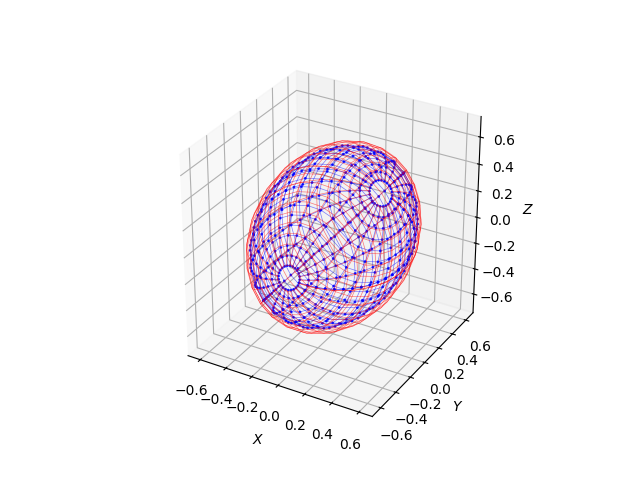

In [255]:
# sample a noisy ellipse
sqrt_m = 25
a, b, c = 0.5,0.6,0.7
yaw, pitch, roll =  30, 30, 30
nu = 1.0e-4
p = 1.6075

m, data, u = inner_problem((a,b,c), (yaw,pitch,roll), sqrt_m, nu, p, method="default", with_jac=False)

Theoretical min surface area is 4.835975862043171
    0 ellipsoid estimate (0.527, 0.641, 0.707, 29.99°, 30.01°, 30.01°) has volume 1.0 and surface area 4.8956. LR 0.4
3.541889643482696 0.020108336390080167
    1 ellipsoid estimate (0.531, 0.637, 0.706, 28.61°, 30.29°, 30.01°) has volume 1.0 and surface area 4.8906. LR 0.4
3.480138688330639 6.483895837954279e-06
    2 ellipsoid estimate (0.538, 0.631, 0.704, 25.88°, 30.92°, 29.73°) has volume 1.0 and surface area 4.8838. LR 0.4
3.380861918074011 2.496977312373083e-05
    3 ellipsoid estimate (0.545, 0.624, 0.701, 21.8°, 31.92°, 28.9°) has volume 1.0 and surface area 4.8772. LR 0.4
3.26584107348431 5.6834881557508156e-05
    4 ellipsoid estimate (0.552, 0.619, 0.699, 16.36°, 33.27°, 27.34°) has volume 1.0 and surface area 4.8722. LR 0.4
3.151937291139845 0.00010396750908583388
    5 ellipsoid estimate (0.557, 0.615, 0.697, 9.676°, 34.87°, 25.03°) has volume 1.0 and surface area 4.8688. LR 0.4
3.0494796903642873 0.0001606395925436943
   

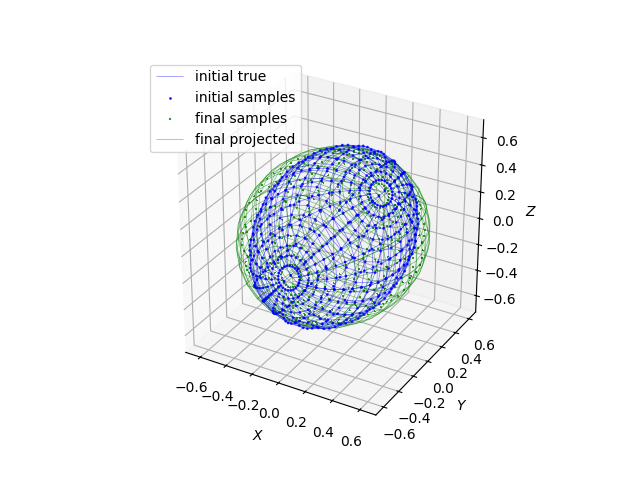

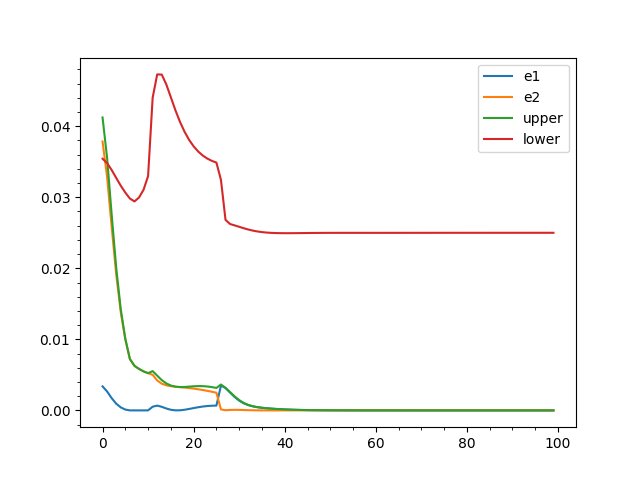

In [256]:
R1 = rotation_matrix_3d(torch.deg2rad(torch.tensor([290,30,10])))
R2 = rotation_matrix_3d(torch.deg2rad(torch.tensor([30,21,40])))
t1 = 1.20899
t2 = 1.20899

lps = (R1, R2, t1, t2)
u = outer_problem(m, data, loss_params=lps, n_iters=100, with_jac=False, lr=0.4, moment=0.7, method="default")

In [ ]:
print(u)

[  0.70693414   0.52685559   0.64097464 340.88771735 131.41389464
  49.09640326]


In [ ]:
print(obtain_coefficients(R1 @ A_from_u(u).float() @ R1.T))
print(obtain_coefficients(R2 @ A_from_u(u).float() @ R2.T))

(tensor([2.5785, 2.2412, 3.0696, 0.0619, 0.1076, 0.5348]), tensor([2.5776, 0.0525, 2.2179]))
(tensor([ 2.2166,  2.6359,  3.0367,  0.2047, -0.4002, -0.3473]), tensor([2.2034, 0.1819, 2.6260]))
